In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from ratio_space import ratiospace_division, nCk, origin_vector
from myutils import get_figratio, plot_hist, cumulative_bins

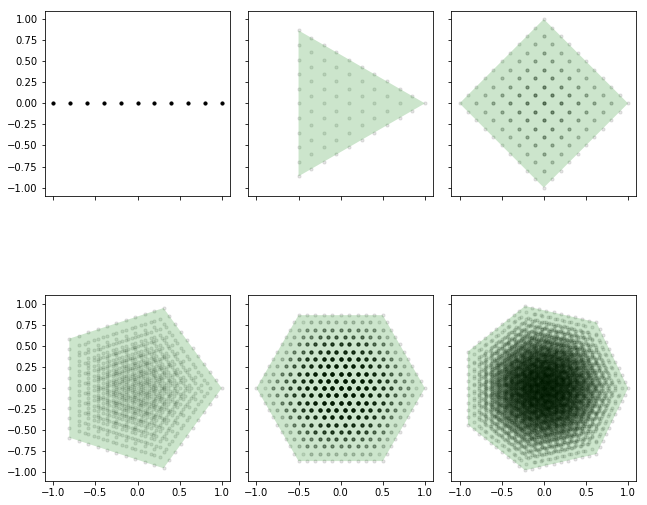

In [2]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 9))
N = 3
K = 10
for N, _ax in enumerate(ax.flat):
    N += 2
    p = origin_vector(ratiospace_division(N,K))
    if N <= 2:
        _ax.scatter(p, np.zeros(len(p)), 10, 'k')
    else:
        _ax.scatter(p.T[0], p.T[1], 10, 'k', alpha=0.1)
        p = origin_vector(ratiospace_division(N,1))
        poly = plt.Polygon(p[:,:2], alpha=0.2, fc='g')
        _ax.add_patch(poly)
    _ax.set_aspect('equal')
    _ax.set_ylim(-1.1, 1.1)
    _ax.set_xlim(-1.1, 1.1)
plt.tight_layout()

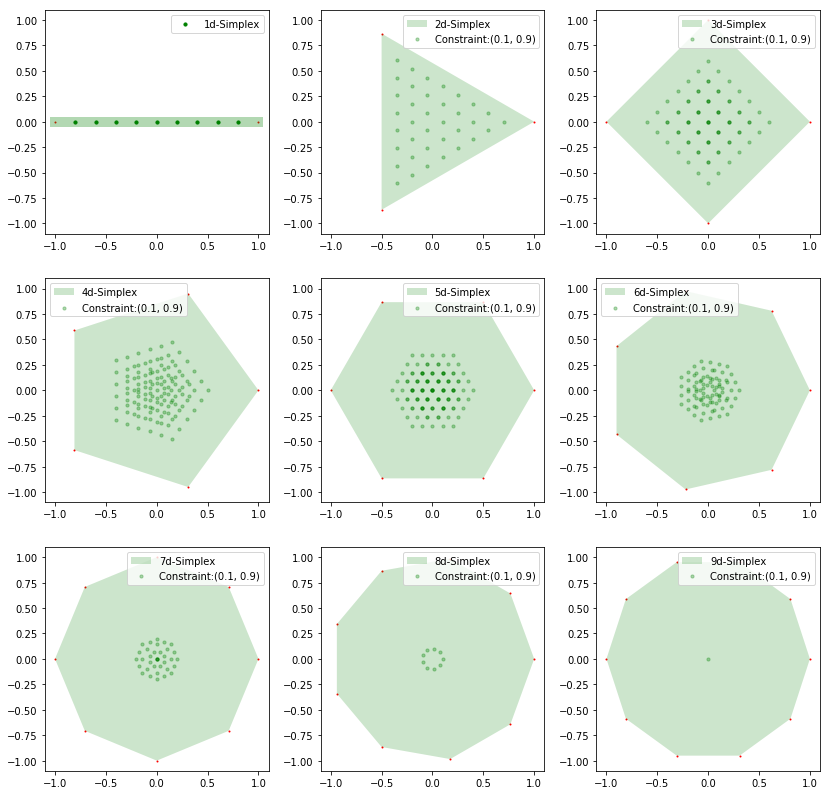

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
N = 6 
K = 10 
for N, _ax in enumerate(ax.flat, start=2):
    p = origin_vector(ratiospace_division(N, 1))
    if N==2:
        _ax.scatter(p, np.zeros(p.shape), 1, 'r')
        _ax.plot(p, np.zeros(p.shape), 'g', alpha=0.3, linewidth=10)
    else:
        _ax.scatter(p.T[0], p.T[1], 1, 'r')
    cons_base = (0.1, 0.9)
    cons = [(0.1, 0.9)]*N
    P = ratiospace_division(N, K, constraints=cons)
    p = origin_vector(P)
    df = pd.DataFrame(np.c_[P, p])
    if N==2:
        _ax.scatter(p, np.zeros(p.shape), 10, 'g', label='1d-Simplex')
    else:
        _ax.scatter(p.T[0], p.T[1], 10, 'g', alpha=0.3, label=f'Constraint:{cons_base}')
        p = origin_vector(ratiospace_division(N,1))
        poly = plt.Polygon(p[:,:2], alpha=0.2, fc='g', label=f'{N-1}d-Simplex')
        _ax.add_patch(poly)
    _ax.legend()
    _ax.set_ylim(-1.1, 1.1)
    _ax.set_xlim(-1.1, 1.1)
    _ax.set_aspect('equal')

# Asset Portfolio

Stock (0.05, 0.1)
FX (0.05, 0.1)
Deposit (0.1, 0.4)
Real Estate (0.3, 0.7)
Portion combination (135, 4)


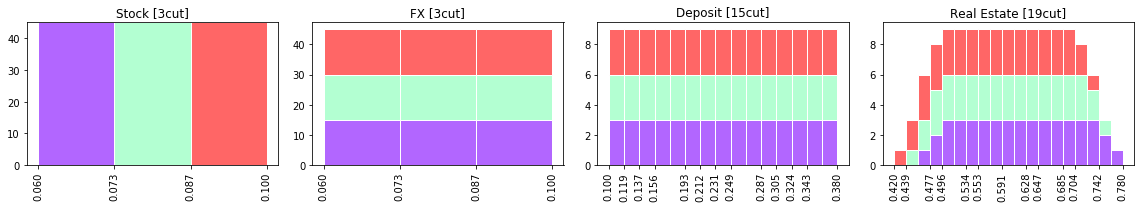

In [4]:
nb_ex = 50

dic = {
    'Stock' : (0.05, 0.1),
    'FX' : (0.05, 0.1),
    'Deposit' : (0.1, 0.4),
    'Real Estate' : (0.3, 0.7),
}

keys = pd.DataFrame(dic, index=['min', 'max']).sort_values('max', 1).columns
cons = [dic[x] for x in keys]
    
for n, c in zip(keys, cons):
    print(n, c)

grid_data = ratiospace_division(4, nb_ex, constraints=cons)
print('Portion combination', grid_data.shape)

fig, ax = plt.subplots(ncols=len(keys), figsize=(16, 3))
label = np.digitize(grid_data[:,0], np.unique(grid_data[:,0]))-1
unique_label = np.unique(label)
color = unique_label/unique_label.max()
color = plt.get_cmap('rainbow')(color)
color[:, -1] = 0.6
for _ax, data, k in zip(ax.flat, grid_data.T, keys):
    unique_data = len(np.unique(data))
    h, e = np.histogram(data, bins=unique_data)
    title=f'{k} [{len(h)}cut]'
    _ax.set_title(title)
    _btm = np.zeros(len(e[:-1]))
    for l, c in zip(np.unique(label), color):
        idx = np.where(label==l)[0]
        h, _ = np.histogram(data[idx], bins=e)
        _ax.bar(e[:-1], h, e[1:]-e[:-1], _btm, align='edge', fc=c, ec='w')
        _btm += h
    _e = e if len(e)<13 else e[np.linspace(0,len(e)-1,13).astype(int)]
    _ax.set_xticks(_e)
    _ax.set_xticklabels([f'{x:.3f}'for x in _e], rotation=90)
plt.tight_layout()

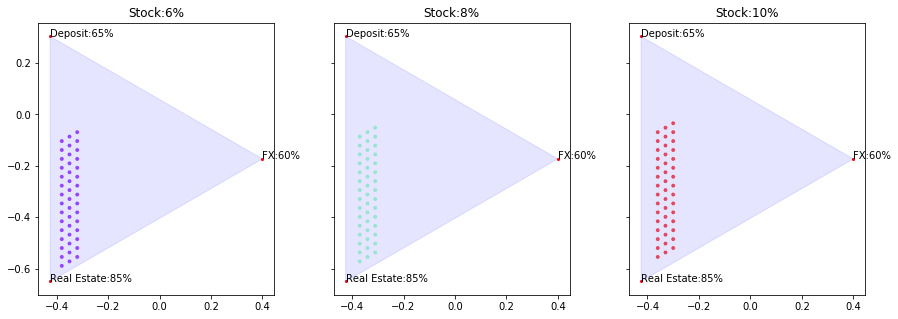

In [5]:
p = np.ones((3, 3))
for i in nCk(3, 2):
    j = list(set(np.arange(3))-set(i))
    for _i in i:
        p[j, _i] = cons[_i+1][0]
    m = p[j]==1
    p[j, j] -= p[j, i].sum()
    
def plot_ratiospace(grid_data, label, p, fname=None):
    ul = np.unique(label)
    nc, nr = get_figratio(len(ul))
    fig, ax = plt.subplots(nr, nc, figsize=(5*nc, 5*nr), sharex=True, sharey=True)
    color = plt.get_cmap('rainbow')(label/label.max())
    for _ax, _ul in zip(ax.flat, ul):
        idx = np.where(_ul==label)[0]
        poly = plt.Polygon(origin_vector(p), alpha=0.1, color='b')
        _p = origin_vector(p)
        _ax.scatter(_p.T[0], _p.T[1], 4, c='r')
        _ax.set_title(f'{keys[0]}:{grid_data[idx][:,0][0]:.0%}')
        for i, _p in enumerate(origin_vector(p)):
            _i = np.argmax(p[i])
            _text = f'{keys[_i+1]}:{p[_i].max():.0%}'
            _ax.text(_p[0], _p[1], _text)
        _ax.add_patch(poly)
        data = origin_vector(grid_data[idx][:,1:])
        _ax.scatter(data.T[0], data.T[1], 10, marker='H', c=color[idx], alpha=0.6)
        _ax.set_aspect('equal')
    if fname:
        fig.suptitle(fname.split('/')[-1])
        plt.savefig(fname)
        plt.close()

plot_ratiospace(grid_data, label, p)

In [6]:
def gen_matrix(edges, data, value=None, func=[np.mean, np.std], return_labels=False, debug=False):
    labels = np.array([np.digitize(d, e, right=True) for e,d in zip(edges, data)]) -1
    _shape = [len(x)-1 for x in edges]
    _shape.append(len(edges))
    if debug:
        print(_shape)
    matrix = np.zeros(tuple(_shape))
    mask = np.ones(matrix.shape[:-1])
    if not value is None:
        stats = np.zeros(tuple(_shape[:-1]+[len(func)]))
    if debug:
        print(data.shape, matrix.shape, labels.shape, mask.shape)
        check = 0
    for i in zip(*np.where(mask)):
        _idx = np.arange(data.shape[-1])
        for j, k in enumerate(i):
            _tmp = np.where(labels[j][_idx]==k)[0]
            _idx = _idx[_tmp]
            if len(_idx)==0:
                break
        if len(_idx)==0:
            continue
        for j in range(len(i)):
            _data = data[j][_idx]
            if len(_data)>0:
                matrix[i][j] = _data.mean()
        if debug:
            print(i, len(_idx), matrix[i], end='\n')
            check += len(_idx)
        if value is None:
            continue
        for j, _f in enumerate(func):
            stats[i][j] = _f(value[_idx])
    if debug:
        print(check)
    if return_labels:
        if not value is None:
            return matrix, stats, labels
        return matrix, labels
    if not value is None:
        return matrix, stats
    return matrix

In [4]:
from sklearn import datasets as ds

In [7]:
dic = ds.load_boston()
dic.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

3 (506, 13) 5 3


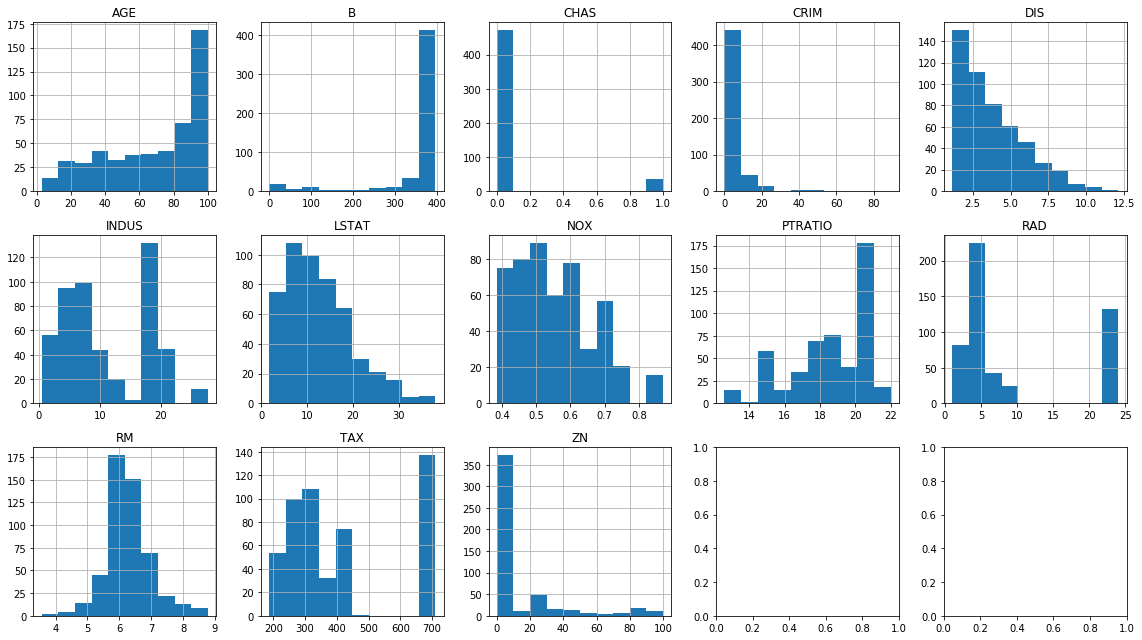

In [47]:
df = pd.DataFrame(dic.data, columns=dic.feature_names)
n = df.shape[1]
nr, nc = get_figratio(n)
fig, ax = plt.subplots(nc, nr, figsize=(16, 9 ))
print(len(ax), df.shape, nr, nc)
df.hist(ax=ax.flat[:n])
fig.tight_layout()

In [45]:

const = {
    'AGE' : 5,
    'B' : 2,
    'CHAS' : 2,
    'CRIM' : 2,
    'DIS' : 
}

cumulative_bins()

<function myutils.cumulative_bins>

In [51]:
for line in dic.DESCR.split('\n'):
    print(line)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

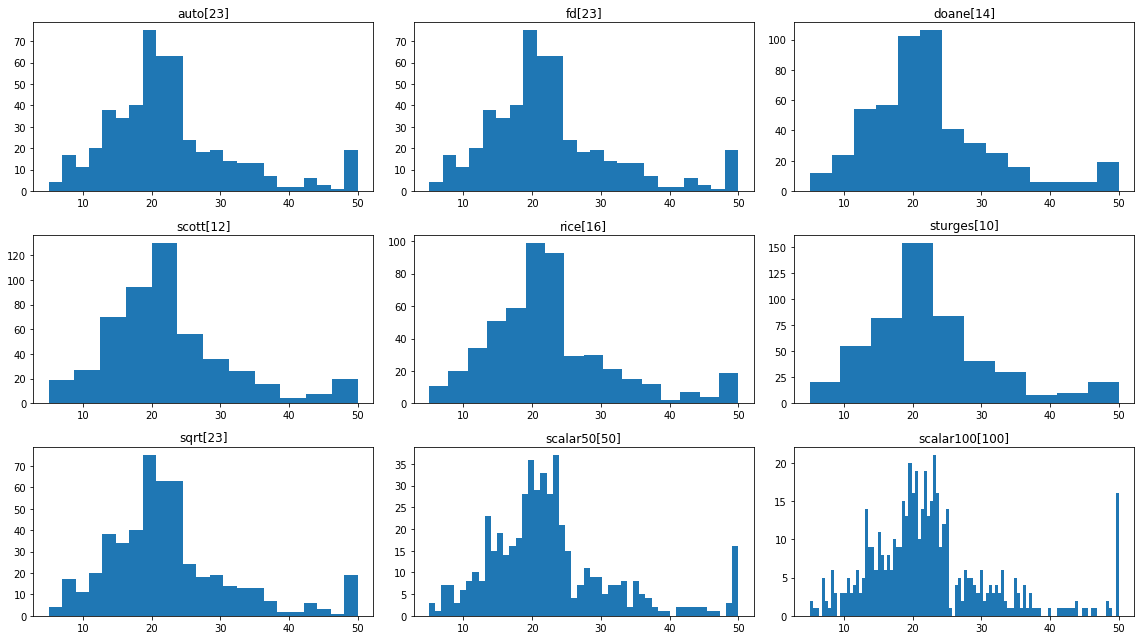

In [53]:
_ = plot_hist(dic.target)